# Differentiable Forwards Modelled Interferrometry

This little tutorial is designed to give an overview of how to forwards-model fit interferrometric observables directly to data, including aberratios and detector effects.

In [1]:
import jax
import jax.numpy as np
import dLux as dl
import dLux.utils as dlu
import zodiax as zdx
import equinox as eqx

from jax import vmap
jax.config.update("jax_enable_x64", True)

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

Here we use webbpsf to get the filter wavelengths and weights

In [2]:

import webbpsf

niriss = webbpsf.NIRISS()  # WebbPSF instrument

niriss.pupil_mask = "MASK_NRM"
niriss.filter = "F480M"
psf_fits = niriss.calc_psf()
niriss_osys = niriss.get_optical_system()
planes = niriss_osys.planes  # [Linear Model WSS, Coord inversion, FDA, NRM, Detector]

# Get modelling wavelengths
wls, wgts = [], []
for i in range(9):
    wls.append(psf_fits[0].header[f"WAVE{i}"])
    wgts.append(psf_fits[0].header[f"WGHT{i}"])
wls = np.array(wls)
wgts = np.array(wgts)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-062 CANNOT BE CHECKED AGAINST ONLINE VERSION


Now we just create a simple dLux object to match the webbpsf one. Note this is just a simple model for testing, and will not match webbpsf exactly.

In [3]:
# Get out parameters from webbpsf
wf_npix = planes[0].amplitude.shape[0]
diam = planes[0].pixelscale.to("m/pix").value * planes[0].npix
pscale = planes[-1].pixelscale.to("arcsec/pix").value  # arcsec
psf_npix = 80
oversample = 4

# Build our layers
layers = [
    ("aperture", dl.Optic(planes[-2].amplitude, planes[0].opd, normalise=True)),
    ("InvertY", dl.Flip(axes=0)),
]

# Construct optics
osys = dl.AngularOpticalSystem(wf_npix, diam, layers, psf_npix, pscale, oversample)

# Get PSF - monochromatic for now to test the mask
psf = osys.propagate(wls[0])

## Generating the splodge mask

Now we want to generate the splodge mask, that is used to apply our complex visibilities in the UV plane. For this, all we need is the position of the holes in meters, and the 'face-to-face' size of the hexagonal holes in meters.

In [4]:
# from .lib import uv_hex_mask, pairwise_vectors, get_baselines
from lib import uv_hex_mask, pairwise_vectors, get_baselines, osamp_freqs
from nrm_analysis.misctools import mask_definitions

# Take holes from ImPlaneIA
holes = mask_definitions.jwst_g7s6c()[1]
f2f = 0.82  # m

# Padding apploed before FFT to UV plane
pad = 2

# Padding to use when calcualte the UV-masks
calc_pad = 2

# Now we calculate the masks
mono_masks = uv_hex_mask(
    holes, f2f, wls[0], pscale, psf_npix, oversample, pad, calc_pad, verbose=True
)

# Get power spectrum
padded = dlu.resize(psf, pad * psf.shape[0])
cplx = np.fft.fftshift(np.fft.fft2(padded))

# Get baseline verctors and baselines
vecs = pairwise_vectors(holes)
bls = get_baselines(holes)

  0%|          | 0/21 [00:00<?, ?it/s]

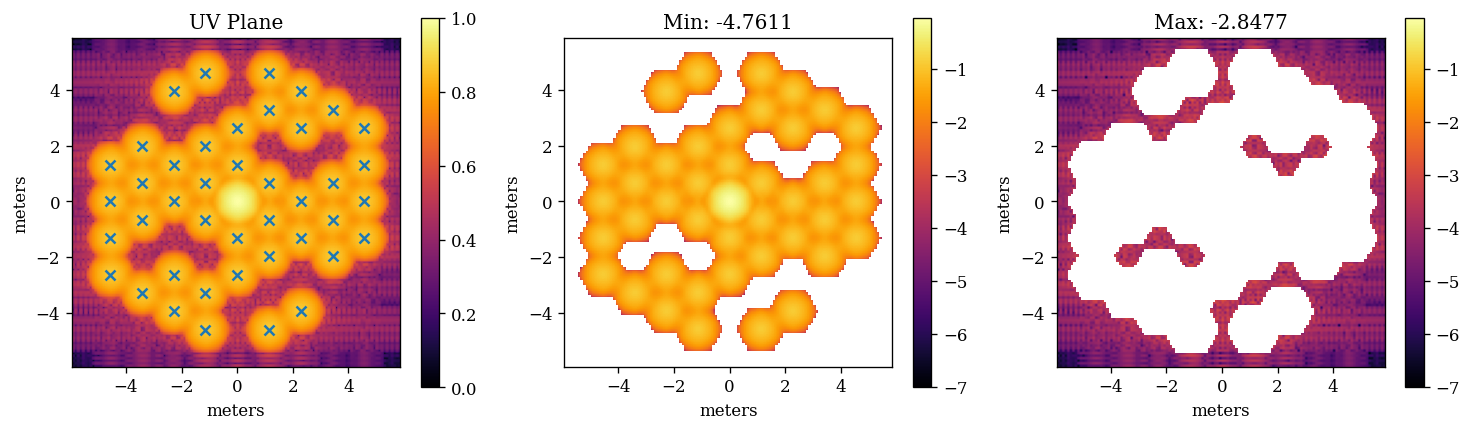

In [5]:
import matplotlib

c = cplx.shape[0] // 2
s = 65
cut = slice(c - s, c + s, 1)

# Get the coordaintes
dx = dlu.arcsec2rad(pscale) / oversample
shifted_coords = osamp_freqs(cplx.shape[0], dx, 1) * wls[0]
rmin, rmax = shifted_coords[cut].min(), shifted_coords[cut].max()
extent = [rmin, rmax, rmin, rmax]

# Get the amplitude and mask
ampl = (np.abs(cplx))[cut, cut]
mask = (mono_masks.sum(0) > 0)[cut, cut]

# Get the inner and outer values of the mask application
inner = ampl * mask
outer = ampl * np.abs(mask - 1)

# Get the log values
logged = np.where(np.log10(ampl) == -np.inf, np.nan, np.log10(ampl))
vmin, vmax = np.nanmin(logged), np.nanmax(logged)

# Get the min and max values from each
inner_mask_min = np.nanmin(np.log10(inner[np.where(mask)]))
masked_outer = np.where(mask, -np.inf, np.log10(outer))
nand_outer = np.where(masked_outer == -np.inf, np.nan, masked_outer)
outer_mask_max = np.nanmax(nand_outer)


# Plot
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)

plt.title("UV Plane")
plt.imshow(np.abs(cplx)[cut, cut], norm=matplotlib.colors.LogNorm(), extent=extent)
plt.scatter(bls[:, 0], -bls[:, 1], marker="x")
plt.xlabel("meters")
plt.ylabel("meters")
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title(f"Min: {inner_mask_min:.4f}")
plt.imshow(np.log10(inner), vmin=vmin, vmax=vmax, extent=extent)
plt.xlabel("meters")
plt.ylabel("meters")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title(f"Max: {outer_mask_max:.4f}")
plt.imshow(np.log10(outer), vmin=vmin, vmax=vmax, extent=extent)
plt.ylabel("meters")
plt.xlabel("meters")
plt.colorbar()
plt.show()

Excellent, as we can see the balelines match up with the splodges and the mask cuts them out perfectly.

Now lets have a look at the mask of each baseline pair so we can see the degree of redundancy in the system.

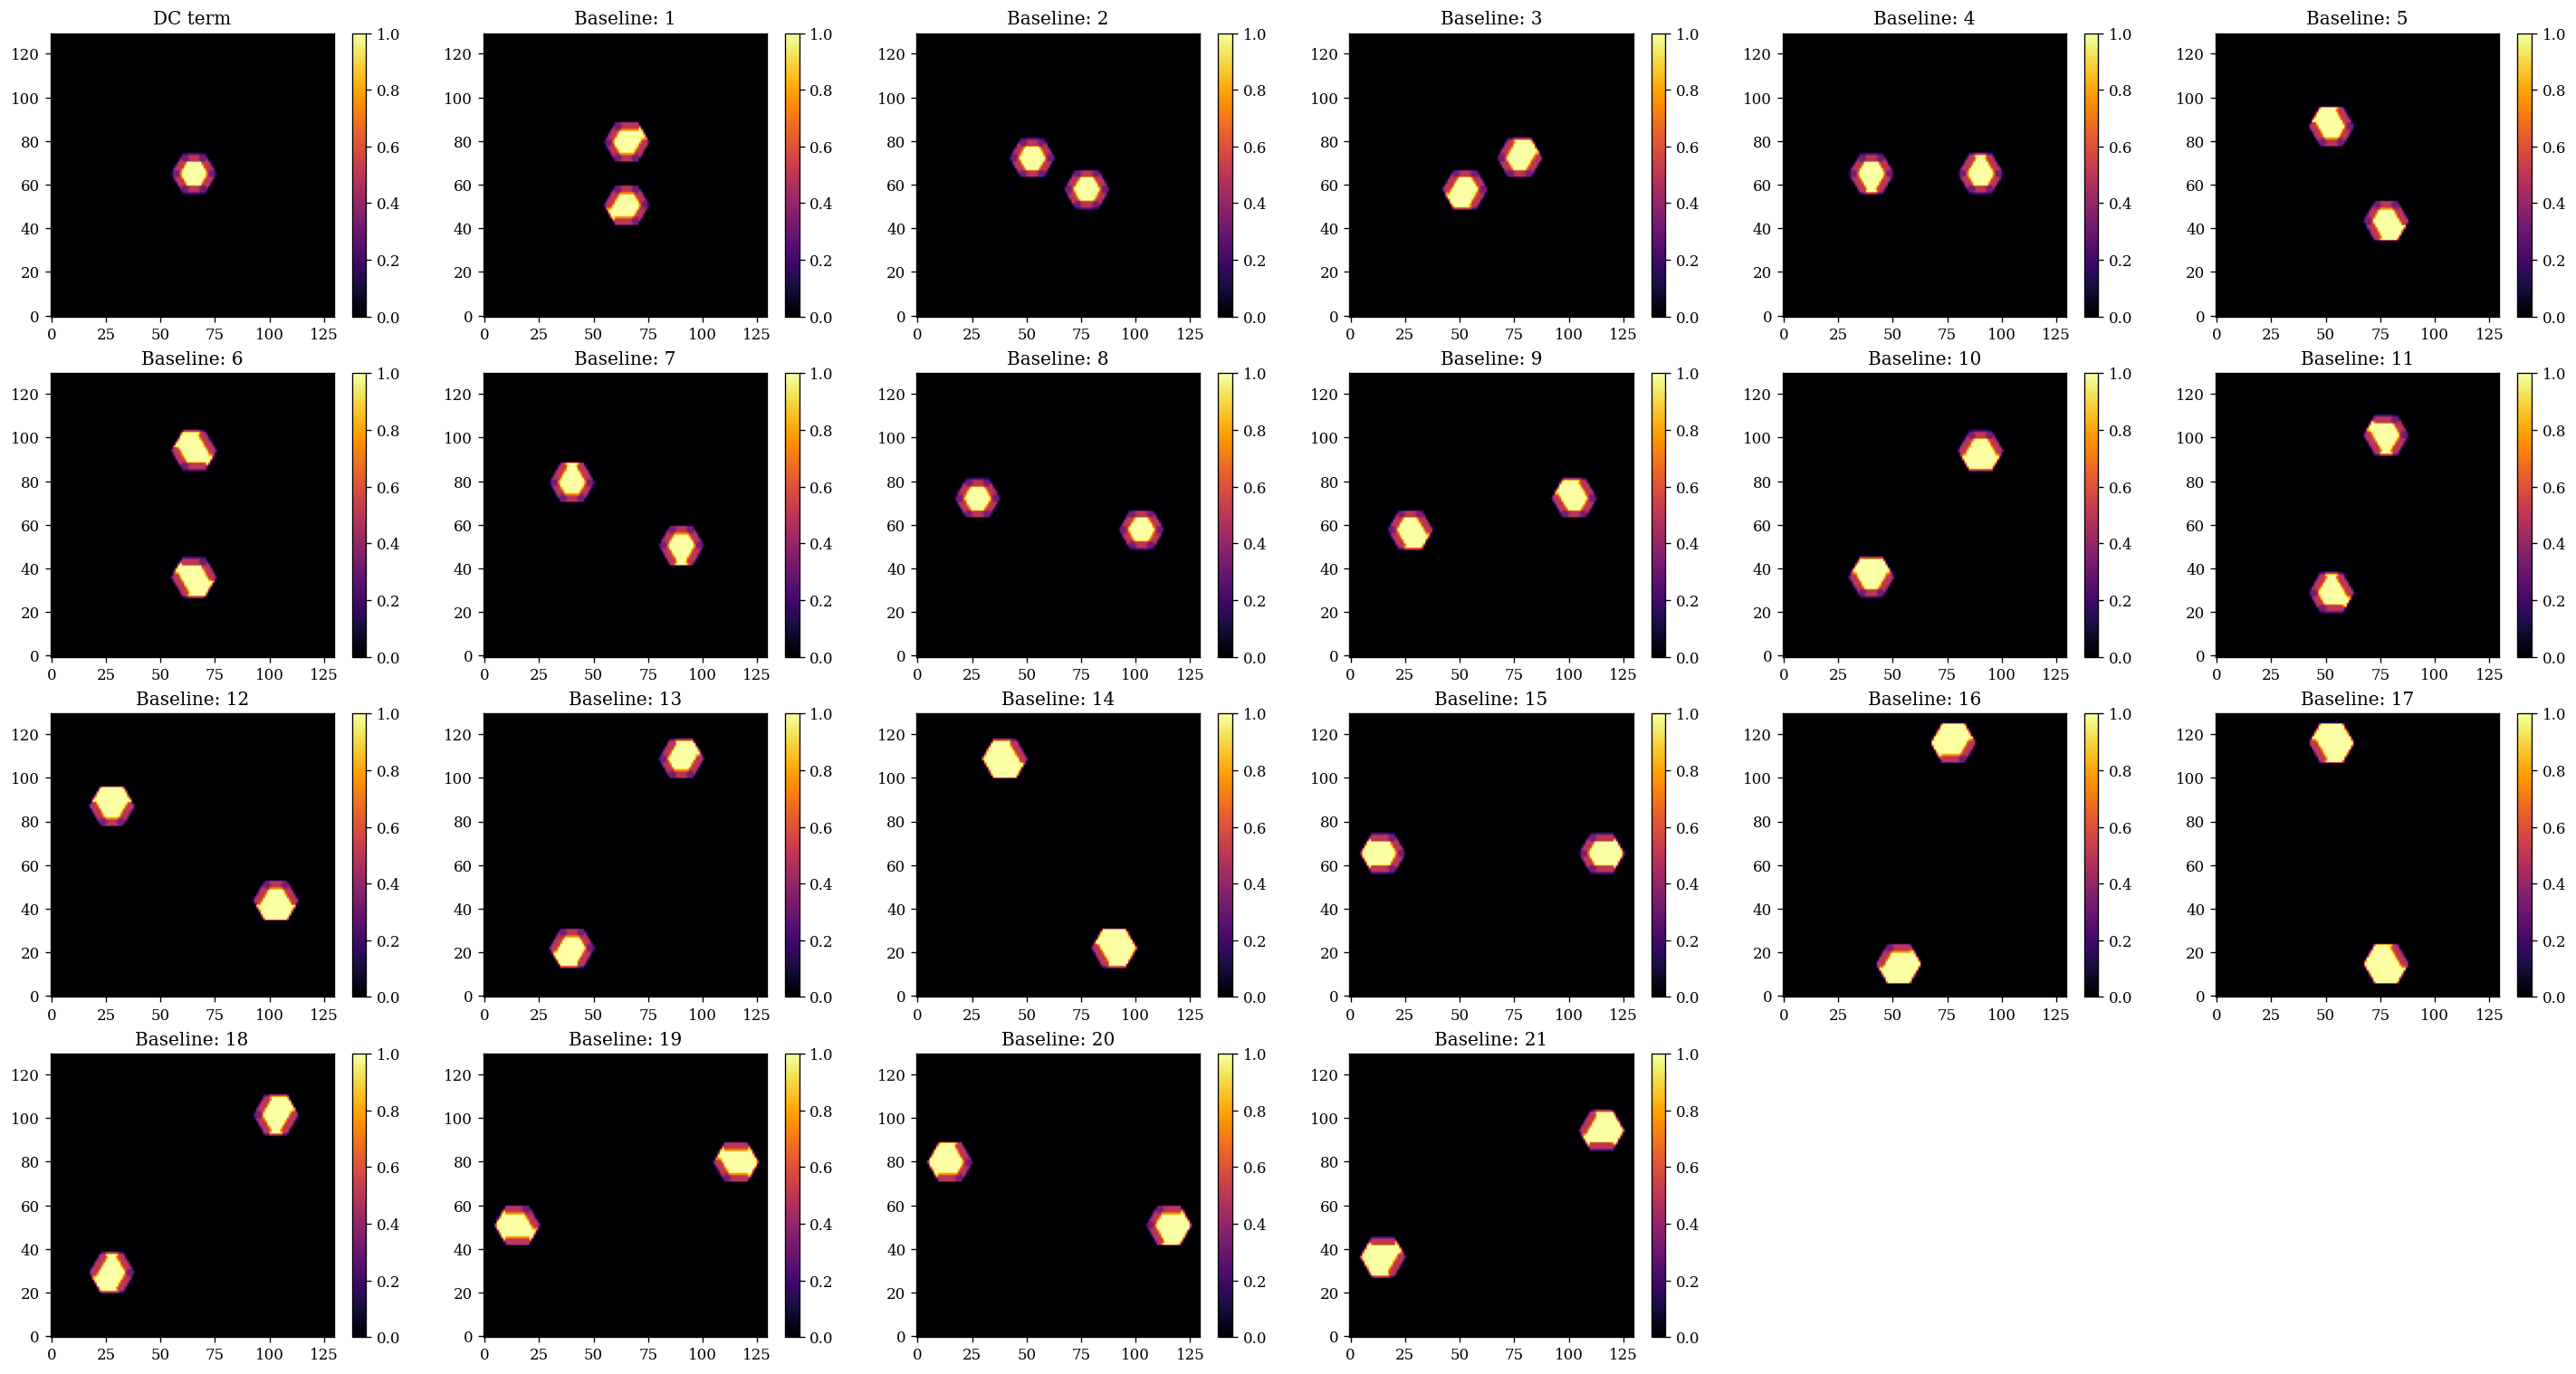

In [6]:
rows, cols = 6, 10
plt.figure(figsize=(5 * rows, 4 * cols))

# Lase value is always the DC term
plt.subplot(cols, rows, 1)
plt.title("DC term")
plt.imshow(mono_masks[-1, cut, cut])  # dc term
plt.colorbar()

# The first half is each individual splodge, and the second half its complex conjugate
for i in range(len(mono_masks) // 2):
    m = mono_masks[i]
    m_conj = mono_masks[i + 21]
    mask_in = m + m_conj
    plt.subplot(cols, rows, i + 2)
    plt.title(f"Baseline: {i+1}")
    plt.imshow(mask_in[cut, cut])
    plt.colorbar()
plt.show()

Sick, now lets generate the full mask for each individual wavelength. Note this is a slow operation, but only needs to be done once.

In [8]:
masks = []
for wavelength in tqdm(wls):
    masks.append(
        uv_hex_mask(
            holes,
            f2f,
            wavelength,
            pscale,
            psf_npix,
            oversample,
            pad,
            calc_pad,
        )
    )
masks = np.array(masks)

  0%|          | 0/9 [00:00<?, ?it/s]

# Build the Source

Now that we have our mask, lets build the source and see what we can do

In [9]:
from lib import UVSource

source = UVSource(wls, masks)
print(source)

# Propagate using normal optics, and also using the source model. Since the 
# visibilities default to uniform, this should give the same PSF
psf = osys.propagate(wls)
psf_out = source.model(osys)

UVSource(
  wavelengths=f64[9],
  weights=f64[9],
  position=f64[2],
  flux=1.0,
  mask=f64[9,43,640,640],
  amplitudes=f64[21],
  phases=f64[21],
  pad=2
)


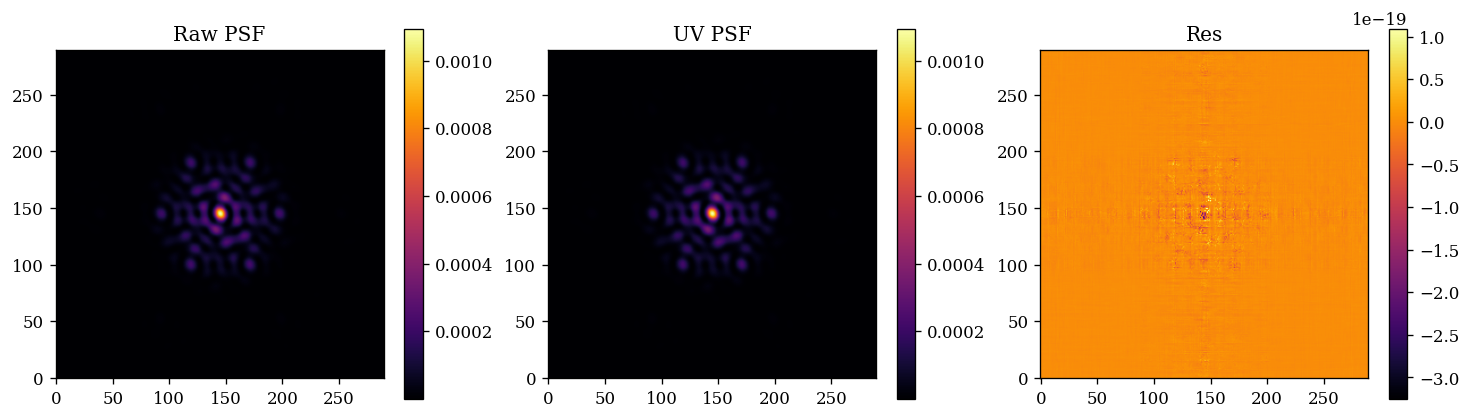

In [10]:
c = psf.shape[0]//2
s = c - 15
psf_cut = slice(c-s, c+s, 1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Raw PSF")
plt.imshow(psf[psf_cut, psf_cut])
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("UV PSF")
plt.imshow(psf_out[psf_cut, psf_cut])
plt.colorbar()

res = psf - psf_out
plt.subplot(1, 3, 3)
plt.title("Res")
plt.imshow(res[psf_cut, psf_cut])
plt.colorbar()

Great, the psf in unchanged! So lets try applying some known visibilities to it (thanks Max).

In [11]:
import scipy
import numpy as onp


def UD_vis2(wavel, diam, u=None, v=None, baseline=None):
    """
    Calculate the squared visibility at a given u, v coord
    or baseline for a uniform disk source morphology.

    Parameters
    ----------
    wavel : float, nanometres
        Wavelength in nm.
    diam : float, radians
        Diameter of the uniform disk in radians.
    u : float, m
        u coordinate in meters.
    v : float, m
        v coordinate in meters.
    baseline : float, m
        Baseline length in meters. If specified u and v are ignored.

    """
    if baseline is None:
        baseline = np.sqrt(u**2 + v**2)  # grabbing baseline length

    wavel *= 1e-9  # nm -> m
    A = np.pi * diam * baseline / wavel
    return (2 * scipy.special.j1(A) / A) ** 2


def GD_vis2(wavel, sigma, u=None, v=None, baseline=None):
    """
    Calculate the squared visibility at a given u, v coord
    or baseline for a uniform disk source morphology.

    Parameters
    ----------
    wavel : float, nanometres
        Wavelength in nm.
    sigma : float, radians
        Standard deviation of the Gaussian disk in radians.
    u : float, m
        u coordinate in meters.
    v : float, m
        v coordinate in meters.
    baseline : float, m
        Baseline length in meters. If specified u and v are ignored.

    Returns
    -------
    vis2 : float
        Squared visibility.
    """
    if baseline is None:
        baseline = np.sqrt(u**2 + v**2)  # grabbing baseline length
    FWHM = 2 * np.sqrt(2 * np.log(2)) * sigma  # FWHM in radians
    wavel *= 1e-9  # nm -> m

    return np.exp(-((np.pi * FWHM * baseline / wavel) ** 2) / (2 * np.log(2)))


def binary_vis2(u, v, wavel, sep, pa, flux_ratio=1):
    """
    Calculate the squared visibility at a given u, v coord
    or baseline for a resolved binary pair.

    See Table 1
    https://ui.adsabs.harvard.edu/abs/2007NewAR..51..576B

    Parameters
    ----------
    u : float, m
        u coordinate in meters.
    v : float, m
        v coordinate in meters.
    wavel : float, nanometres
        Wavelength in nm.
    sep : float, degrees
        Angular separation of the binary pair in radians.
    pa : float, radians
        Position angle of the binary pair in radians.
    flux_ratio : float = 1
        Ratio of the flux of the secondary to the primary. Must be between (0, 1].

    Returns
    -------
    vis2 : float
        Squared visibility.
    """
    if flux_ratio > 1 or flux_ratio <= 0:
        raise ValueError("flux_ratio must be between (0, 1].")

    if baseline is None:
        baseline = np.sqrt(u**2 + v**2)  # grabbing baseline length

    wavel *= 1e-9  # nm -> m

    # angular separation vector in radians
    rho = np.array([sep * np.sin(pa), sep * np.cos(pa)])

    # dot product between baseline vector and angular separation vector
    dot = np.dot(np.array([u, v]), rho)

    return (
        1 + flux_ratio**2 + 2 * flux_ratio * np.cos(2 * np.pi / (wavel * dot))
    ) / (1 + flux_ratio) ** 2

In [12]:
from jax.scipy.stats import norm, multivariate_normal

vis_fn = GD_vis2  # Use a gaussian disk

# Gaussian properties
sigma = 0.05  # arcsec

# Get the Baselines to calcaulte the visibilites on
hbls = pairwise_vectors(holes)
bls_r = onp.array(np.hypot(hbls[:, 0], hbls[:, 1]))

# This code need classic numpy arrays
wls_onp = onp.array(wls)
diam_onp = onp.array(dlu.arcsec2rad(sigma))

vis = []
for bl in bls_r:
    visses = []
    for wavel in wls_onp:
        visses.append(vis_fn(wavel * 1e9, diam_onp, baseline=bl))
    vis.append(np.array(visses).mean(0))

vis = np.array(vis)
ampl = np.sqrt(vis)

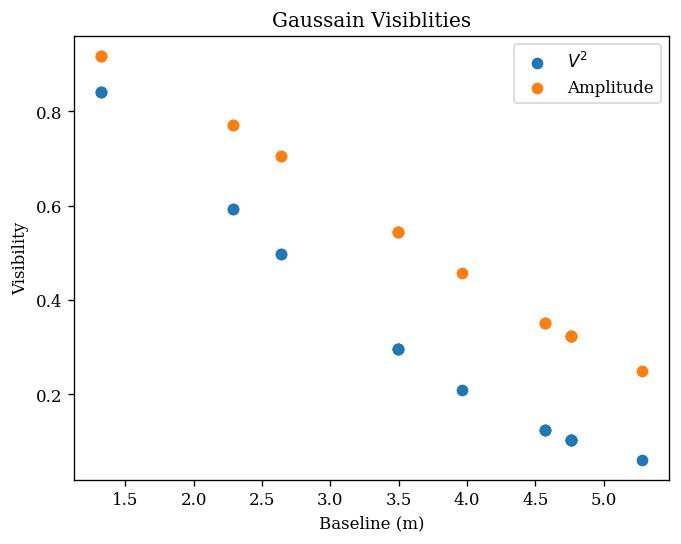

In [13]:
plt.title("Gaussain Visiblities")
plt.scatter(bls_r, vis, label='$V^2$')
plt.scatter(bls_r, ampl, label='Amplitude')
plt.legend()
plt.ylabel("Visibility")
plt.xlabel("Baseline (m)")
plt.show()

Cool, now we just need to update our source to hold this visibilites. We will also plot the 'applied' visiblities to make sure they are correct.

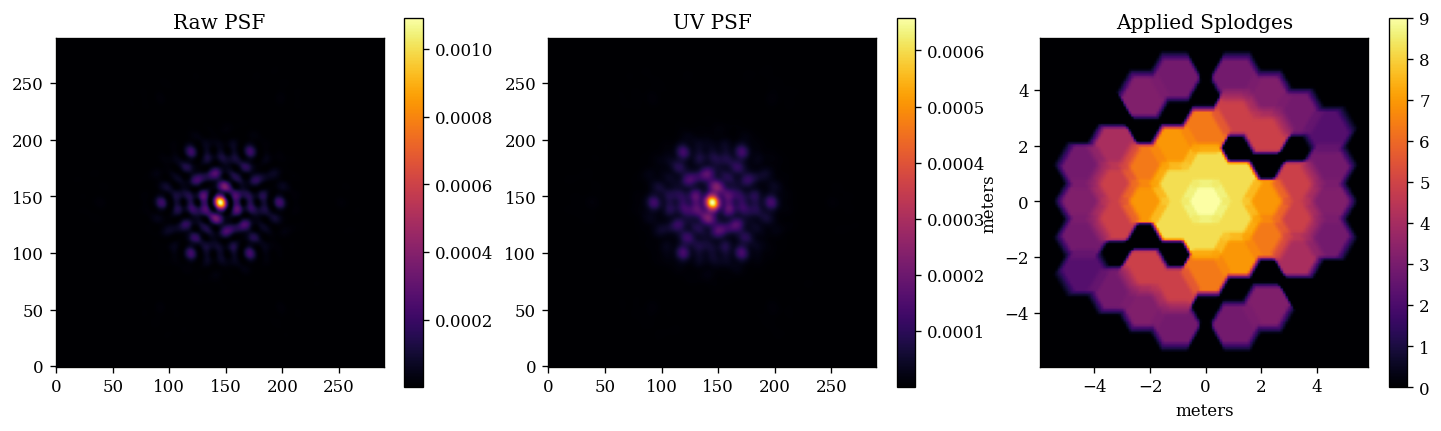

In [14]:
# Plot the 'Splodge mask'
gauss_source = source.set("amplitudes", ampl)
gauss_psf = gauss_source.model(osys)
splodges = gauss_source.splodges


plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.title("Raw PSF")
plt.imshow(psf[psf_cut, psf_cut])
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("UV PSF")
plt.imshow(gauss_psf[psf_cut, psf_cut])
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Applied Splodges")
plt.imshow(np.abs(splodges).sum(0)[cut, cut], extent=extent)
plt.colorbar()
plt.xlabel("meters")
plt.ylabel("meters")

plt.show()

Awesome, as we can see we have a cool looking splodge mask, and a blurred psf. Now lets compare it to its convolved couter-part

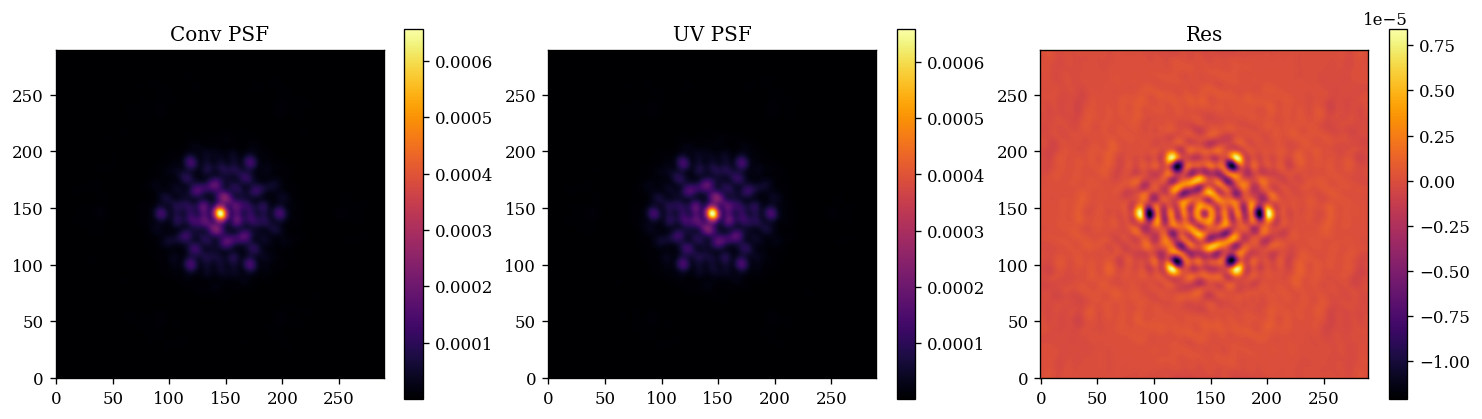

In [15]:
# Generate the gausssina, note we need a 0.5 pixel shift here due to FFT centering
true_pscale = pscale / oversample
coords = dlu.pixel_coords(psf_npix, true_pscale * psf_npix) + (0.5 * true_pscale)
pos = np.dstack([coords[0], coords[1]])
gauss = multivariate_normal.pdf(pos, np.zeros(2), np.eye(2) * sigma**2)
gauss /= gauss.sum()

# Convolve with the PSF
PSF = dl.PSF(psf, true_pscale)
conv_psf = PSF.convolve(gauss).data


plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Conv PSF")
plt.imshow(conv_psf[psf_cut, psf_cut])
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("UV PSF")
plt.imshow(gauss_psf[psf_cut, psf_cut])
plt.colorbar()

res = conv_psf - gauss_psf
plt.subplot(1, 3, 3)
plt.title("Res")
plt.imshow(res[psf_cut, psf_cut])
plt.colorbar()
plt.show()

Pretty close, but why is it different? Well since we are applying a 'piston' mask to the splodges, we do not get any detail _within_ a splodge. In reality the splodge would 'slope' away from the center, which we don't do here. Down the line we will add the ability to have tip-tilt terms, and per-pixel visiblities, but for now this is a fine approximation.

Now lets see if we can take some Fisher matrices with respect to our visibilities.

In [17]:
# Load source and optics into a telescope object
tel = dl.Telescope(osys, source)

log_fluxes = np.arange(4, 8)

stds = []
for log_flux in tqdm(log_fluxes):
    model = tel.set("source.flux", 10**log_flux)
    lfn = zdx.poiss_loglike
    cov = zdx.self_covariance_matrix(model, "amplitudes", lfn)
    stds.append(np.sqrt(np.diag(cov)))

  0%|          | 0/4 [00:00<?, ?it/s]

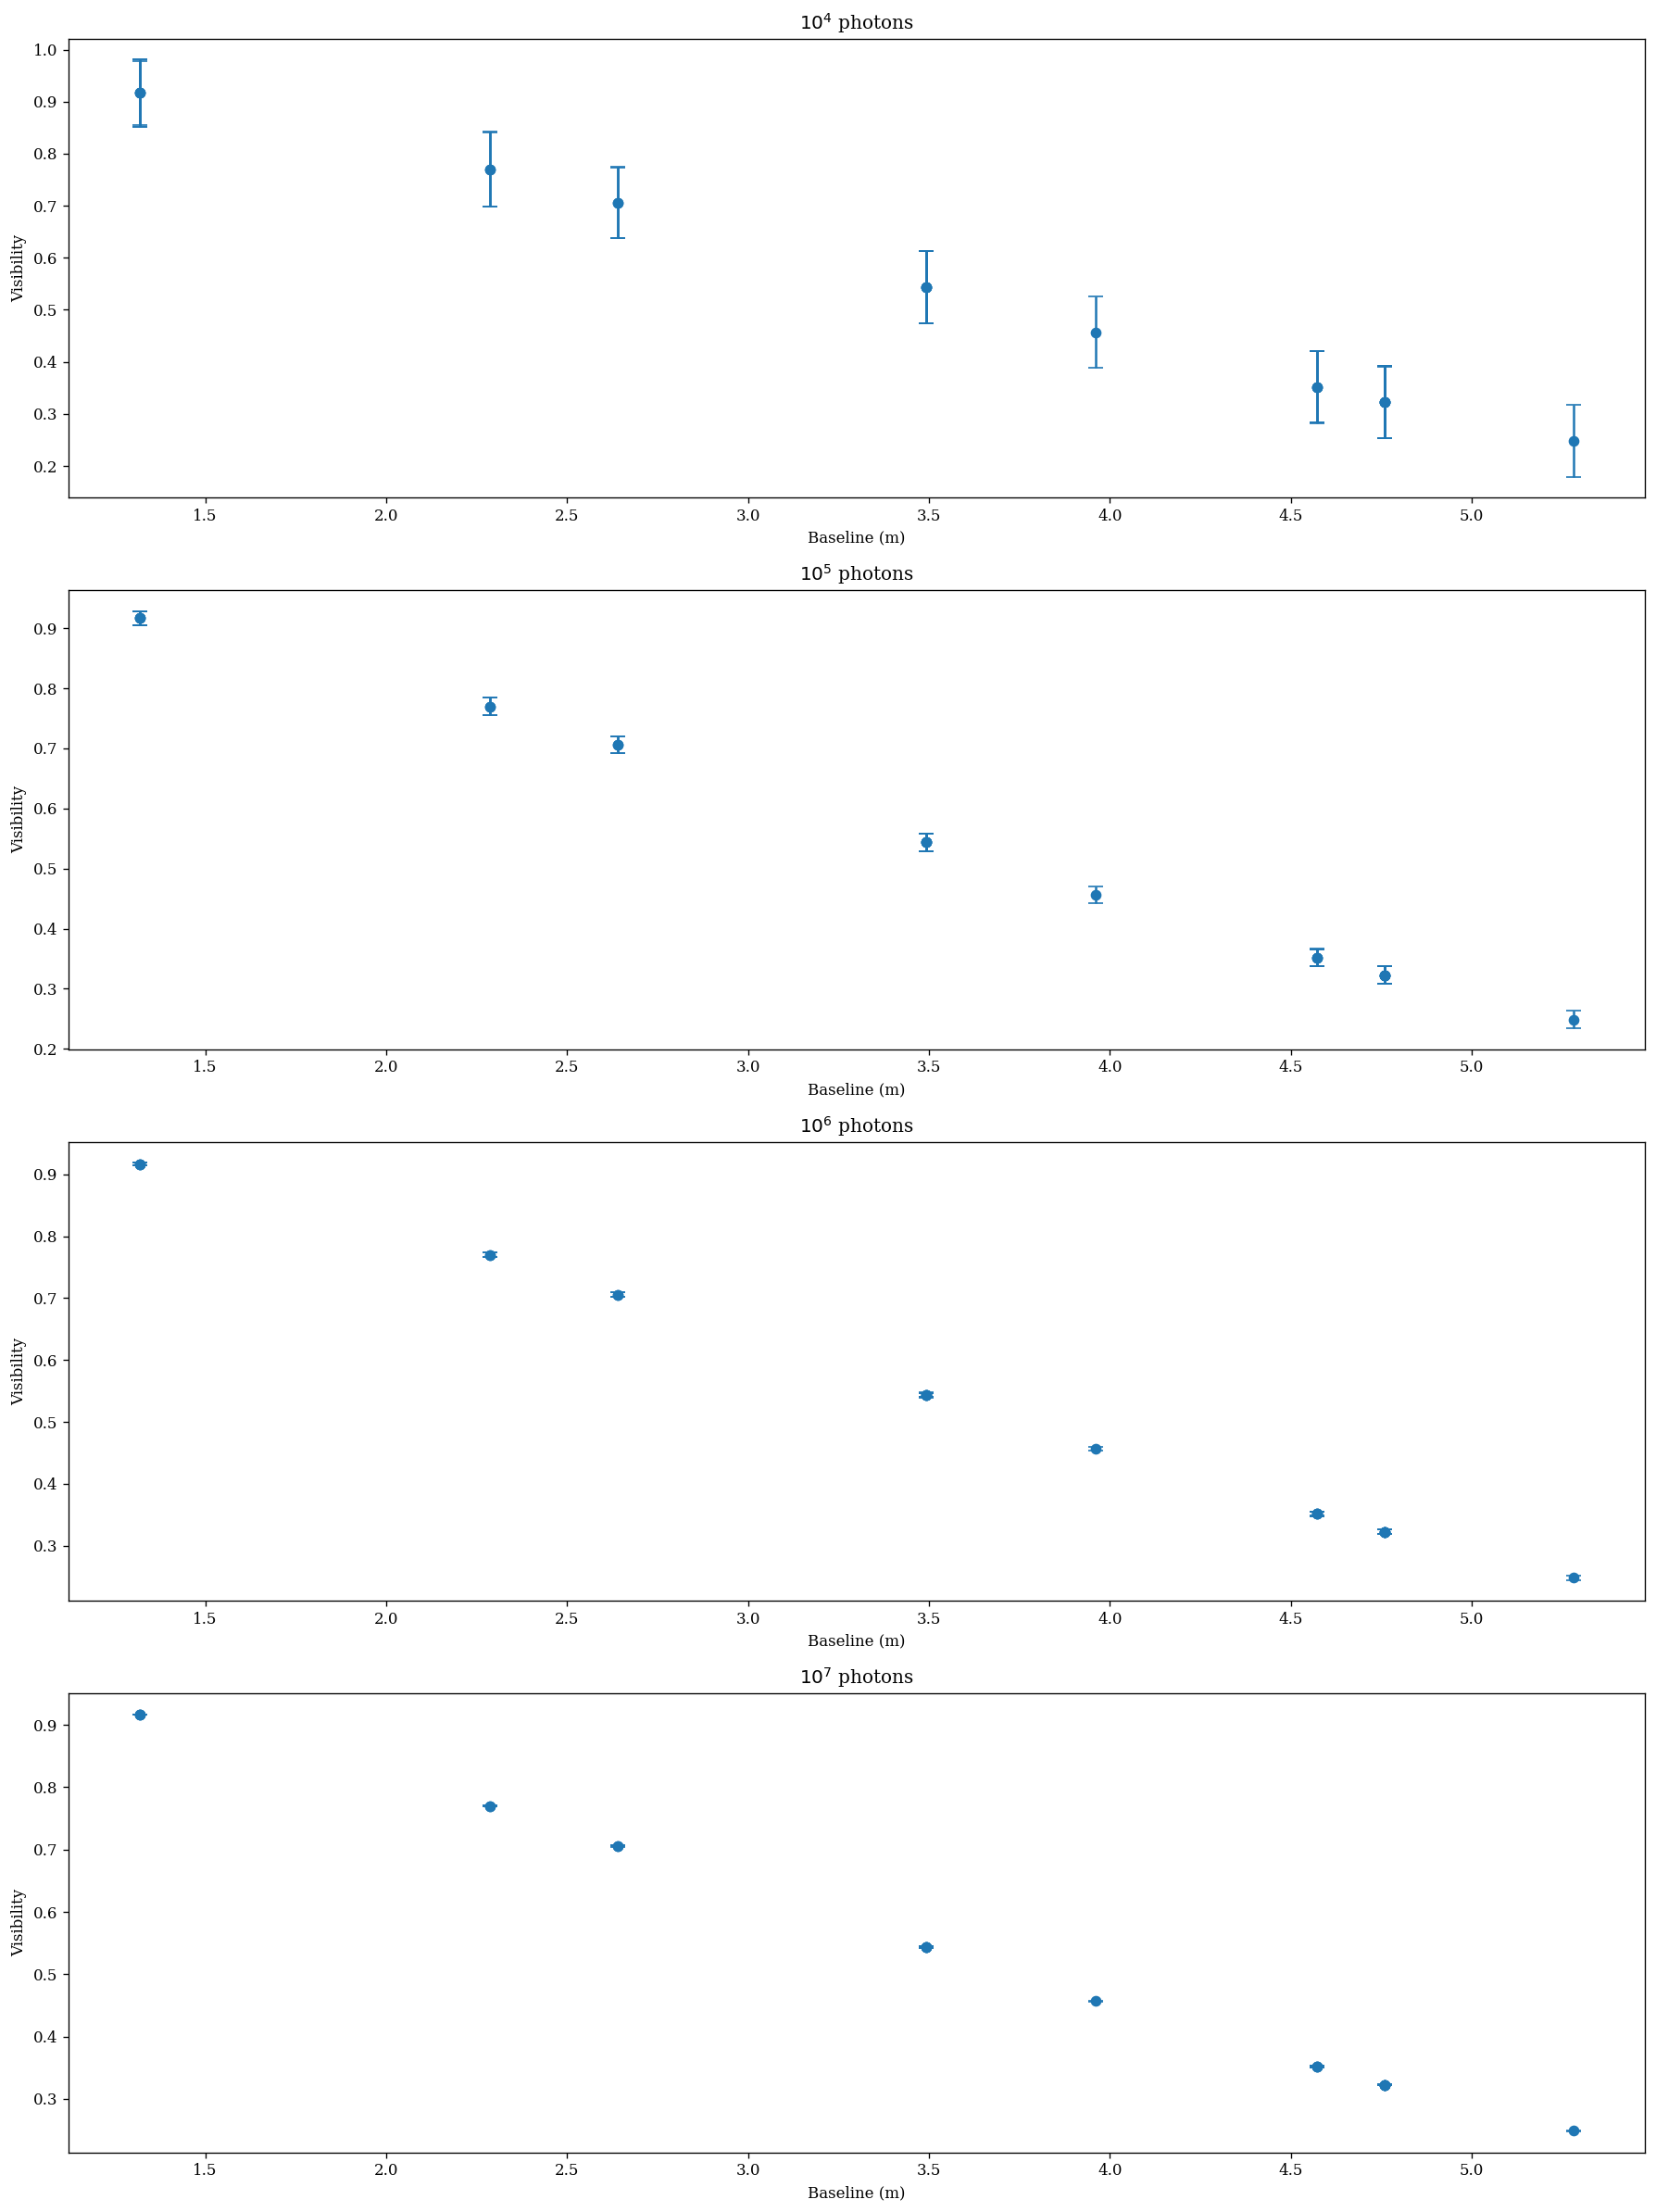

In [18]:
plt.figure(figsize=(15, 20))
for i in range(len(stds)):
    plt.subplot(4, 1, i+1)
    plt.title(f"$10^{log_fluxes[i]}$ photons")
    plt.errorbar(bls_r, gauss_source.amplitudes, yerr=stds[i], fmt="o", capsize=5)
    plt.ylabel("Visibility")
    plt.xlabel("Baseline (m)")
plt.tight_layout()
plt.show()